In [1]:
# Using clustering for preprocessing

from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits)

In [3]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [4]:
# baseline 
log_reg.score(X_test, y_test)

0.9622222222222222

In [5]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, n_init='auto', random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans',
                 KMeans(n_clusters=50, n_init='auto', random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [6]:
pipeline.score(X_test, y_test)

0.9777777777777777

In [7]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] END ...............................kmeans__n_clusters=2; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.3s
[CV] END ...............................kmeans_

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, n_init='auto',
                                               random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

In [8]:
grid_clf.best_params_

{'kmeans__n_clusters': 54}

In [9]:
grid_clf.score(X_test, y_test)

0.9822222222222222

In [10]:
# using clustering for semi-supervised learning

n_labeled = 50
log_reg = LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [11]:
log_reg.score(X_test, y_test)

0.8022222222222222

In [12]:
import numpy as np
k = 50
kmeans = KMeans(n_clusters=k, n_init='auto', max_iter=5000, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

<function matplotlib.pyplot.show(close=None, block=None)>

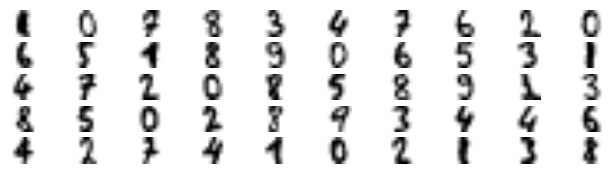

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')
plt.show

In [14]:
y_train[representative_digit_idx]

array([1, 0, 7, 8, 3, 4, 7, 6, 2, 0, 6, 5, 1, 8, 9, 0, 6, 5, 3, 1, 4, 7,
       2, 0, 8, 5, 8, 9, 1, 3, 8, 5, 0, 2, 8, 9, 3, 4, 4, 6, 4, 2, 7, 4,
       1, 0, 2, 1, 3, 8])

In [15]:
# normally we should manually label those representative digits (i.e. semi-supervised learning) but we have cheated here, using the labels in y_train
y_representative_digits = y_train[representative_digit_idx]

In [16]:
log_reg = LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [17]:
log_reg.score(X_test, y_test)

0.9066666666666666

In [19]:
# propagate the labels
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

In [20]:
log_reg = LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.9133333333333333

In [25]:
# propagate the labels to only the 20% of the instances that are closest to the centroids

percentile_closest = 20

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]  # This is an array of distances from the instances to their cluster centroids
for i in range(k):
    in_cluster = (kmeans.labels_ == i)  # array of booleans indicating whether or not that instance is in the i-th cluster
    cluster_dist = X_cluster_dist[in_cluster]  # array of distances from instances in the i-th cluster to the i-th cluster centroid.
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)  # the distance that is at 20% of the distances in the array.
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1  # mark the instances in this cluster but beyong 20% distance cutoff to the centroid.

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [26]:
log_reg = LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.9111111111111111

In [27]:
# check how accurate the propagated labels are
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9965156794425087

In [28]:
# DBSCAN

from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [29]:
dbscan.labels_

array([ 0, -1,  1,  0,  2,  1, -1,  1, -1,  0,  0,  0,  2,  2,  0, -1,  0,
        0,  2,  0,  0,  3,  0,  5,  0,  3,  3,  2,  0,  1,  2, -1,  2,  1,
        1,  3,  0,  0,  3,  0,  2, -1,  4,  5,  3,  3,  0,  1,  0,  2,  1,
        0,  0,  5,  3,  4,  5,  2,  0,  3,  3,  1,  0,  1,  3,  0,  1,  0,
        1, -1,  1,  0,  1,  0,  0,  3,  0,  2,  0,  1,  1,  3,  3,  3,  1,
        1,  2,  5,  2,  4,  3,  1,  0,  6,  0,  1,  0,  3,  0,  1, -1,  0,
        2,  0,  3,  3,  0, -1,  0,  0,  0,  0,  0,  4,  3,  1, -1,  0,  3,
        2,  0, -1,  3,  5,  0,  0,  0,  4,  0,  3, -1,  1, -1,  0,  7,  0,
        3,  3,  0,  5,  5,  5,  0,  1,  0,  3,  3,  1,  5,  0,  5,  0,  0,
        5,  4,  0,  5,  2,  0,  4,  0, -1, -1,  3,  3,  0,  2,  0,  0,  0,
       -1,  3,  1, -1,  3,  3,  1,  5, -1,  3,  3,  1,  0,  5, -1,  3,  0,
        3,  1,  3,  1,  3,  0, -1,  3,  1,  1,  5,  0,  1,  2, -1,  0,  0,
        1,  5,  0,  4,  3,  3, -1,  1,  5,  0, -1,  5,  1,  6,  1,  2,  0,
        3,  1,  5, -1,  5

In [30]:
len(dbscan.core_sample_indices_)

791

In [31]:
dbscan.core_sample_indices_

array([  0,   2,   3,   4,   5,   7,   9,  10,  11,  12,  13,  14,  16,
        17,  18,  19,  20,  21,  22,  25,  26,  27,  28,  29,  30,  32,
        33,  34,  35,  36,  37,  39,  40,  42,  43,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  81,  82,  83,  84,  85,  86,  88,  89,
        90,  91,  92,  95,  96,  97,  98,  99, 101, 102, 103, 104, 105,
       106, 108, 109, 110, 111, 112, 115, 117, 118, 119, 120, 122, 124,
       125, 126, 127, 128, 131, 133, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 160, 163, 164, 165, 166, 167, 168, 169, 171,
       172, 174, 175, 176, 180, 181, 183, 185, 186, 187, 188, 189, 190,
       191, 192, 194, 195, 196, 197, 198, 199, 200, 203, 207, 208, 209,
       211, 212, 213, 215, 216, 217, 218, 219, 220, 221, 222, 22

In [32]:
dbscan.components_

array([[ 1.30503519, -0.49067066],
       [ 0.11221383,  0.15970855],
       [ 1.53627624, -0.38704317],
       ...,
       [ 0.39704945, -0.2669421 ],
       [ 1.00232739,  0.3526853 ],
       [ 1.68388672, -0.25634567]])

In [33]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8])

In [34]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [35]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

In [36]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

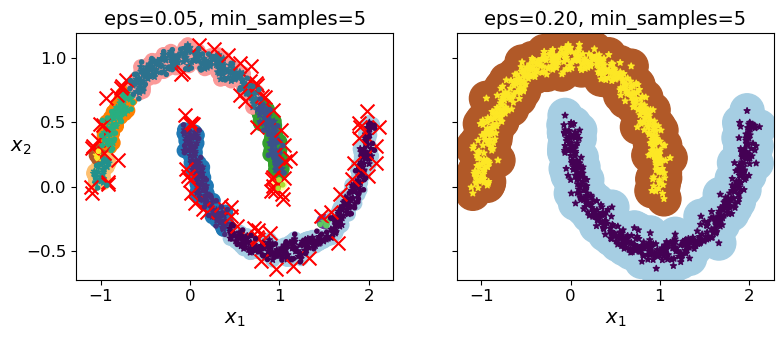

In [37]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()

In [45]:
# train a KNeighborsClassifier to classify a new instance into clusters

from sklearn.neighbors import KNeighborsClassifier
dbscan = dbscan2
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [46]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0])

In [47]:
knn.predict_proba(X_new)

array([[0.2, 0.8],
       [1. , 0. ],
       [0.2, 0.8],
       [1. , 0. ]])

In [49]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)


def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)


def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

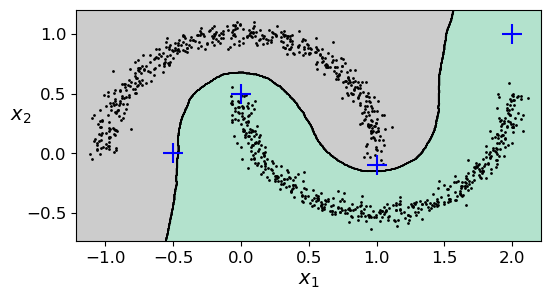

In [51]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
plt.show()

In [57]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1])

In [75]:
# Gaussian Mixtures
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture

X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

gm = GaussianMixture(n_components=3, n_init=10)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10)

In [76]:
gm.weights_

array([0.39001325, 0.20995017, 0.40003658])

In [77]:
gm.means_

array([[ 0.05073145,  0.07465258],
       [ 3.39538947,  1.05916297],
       [-1.40768888,  1.42713433]])

In [78]:
gm.covariances_

array([[[ 0.68824757,  0.79639412],
        [ 0.79639412,  1.21263534]],

       [[ 1.15612128, -0.03262113],
        [-0.03262113,  0.95397372]],

       [[ 0.63475202,  0.72970008],
        [ 0.72970008,  1.16091369]]])

In [79]:
gm.converged_

True

In [80]:
gm.n_iter_

7

In [81]:
gm.predict(X)

array([0, 0, 2, ..., 1, 1, 1])

In [82]:
gm.predict_proba(X)

array([[9.76126594e-01, 2.38727329e-02, 6.73517198e-07],
       [9.82217499e-01, 1.71092370e-02, 6.73264299e-04],
       [7.45175332e-05, 2.23247782e-06, 9.99923250e-01],
       ...,
       [4.22379480e-07, 9.99999578e-01, 2.09065921e-26],
       [4.97555749e-16, 1.00000000e+00, 1.41599975e-41],
       [2.20832463e-15, 1.00000000e+00, 7.75368651e-41]])

In [83]:
X_new, y_new = gm.sample(6)
X_new

array([[ 0.31766908,  0.32230905],
       [-0.35427716, -0.34689229],
       [ 3.08562341,  0.88703022],
       [ 3.3704652 ,  0.6822701 ],
       [-2.70132605,  0.05577811],
       [-1.33741732,  1.13439801]])

In [84]:
y_new

array([0, 0, 1, 1, 2, 2])

In [85]:
gm.score_samples(X)

array([-2.60801574, -3.57163765, -3.33046947, ..., -3.51337294,
       -4.39918415, -3.80966459])

In [86]:
# Let's check that the PDF integrates to 1 over the whole space.
# We just take a large square around the clusters, and chop it into a grid of tiny squares,
# then we compute the approximate probability that the instances will be generated in each tiny square
# (by multiplying the PDF at one corner of the tiny square by the area of the square),
# and finally summing all these probabilities). The result is very close to 1:

resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.9999999999122492

In [87]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')

    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

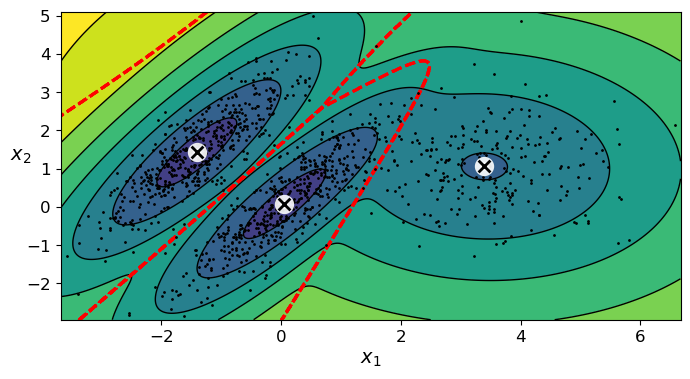

In [88]:
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X)
plt.show()